# Machine Learning and NLP Exercises #

In [1]:
import nltk
import pandas as pd

In [2]:
data = pd.read_csv('data/coffee.csv')
data.head()

,user_id,stars,reviews
0,A2XP9IN4JOMROD,1,I wanted to love this. I was even prepared for...
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups were excellent. T...
2,AJ3L5J7GN09SV,2,I bought the Grove Square hazelnut cappuccino ...
3,A3CZD34ZTUJME7,1,"I love my Keurig, and I love most of the Keuri..."
4,AWKN396SHAQGP,1,It's a powdered drink. No filter in k-cup.<br ...


In [3]:
data.reviews.isna().sum()

0

In [4]:
data.stars.value_counts()

5    308
1     96
4     65
2     45
3     28
Name: stars, dtype: int64

In [5]:
data = data[data.stars!=3]

In [6]:
def sentiment_value (star):
    return 'positive' if star >= 4 else 'negative'

In [7]:
data['sentiments'] = data.stars.map(sentiment_value)
data = data.drop(['stars', 'user_id'], axis = 1)

In [8]:
data.head(1)

,reviews,sentiments
0,I wanted to love this. I was even prepared for...,negative


In [9]:
data.sentiments.value_counts().sum()

514

In [10]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

data['reviews'] = data.reviews.map(alphanumeric).map(punc_lower)
data.head()

,reviews,sentiments
0,i wanted to love this i was even prepared for...,negative
1,grove square cappuccino cups were excellent t...,positive
2,i bought the grove square hazelnut cappuccino ...,negative
3,i love my keurig and i love most of the keuri...,negative
4,it s a powdered drink no filter in k cup br ...,negative


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")
X = cv.fit_transform(data.reviews).toarray()

dtcv_uni = pd.DataFrame(X, columns=cv.get_feature_names())
dtcv_uni.head(1)

,able,abomination,absolute,absolutely,acceptable,accident,acidy,actual,actually,add,...,years,yes,yessiree,yesterday,york,yuck,yucky,yum,yummy,yup
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
cv = CountVectorizer(stop_words="english", ngram_range=(1, 2), binary = True)
X2 = cv.fit_transform(data.reviews).toarray()

dtcv_bi = pd.DataFrame(X2, columns=cv.get_feature_names())
dtcv_bi.head(1)

,able,able cappuccino,able drink,able finish,able longer,able make,able return,able switch,abomination,abomination bet,...,yummy perfect,yummy price,yummy real,yummy run,yummy strong,yummy suitable,yummy treat,yummy won,yup,yup exactly
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_vector = tfidf.fit_transform(data.reviews)

dt_tfidf = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf.get_feature_names())

In [14]:
target = data.sentiments

In [15]:
from sklearn.model_selection import train_test_split

X_train_uni, X_test_uni, y_train_uni, y_test_uni = train_test_split(dtcv_uni, target, test_size=0.3, random_state=42)
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(dtcv_bi, target, test_size=0.3, random_state=42)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(dt_tfidf, target, test_size=0.3, random_state=42)

In [16]:
from sklearn.linear_model import LogisticRegression 

LR = LogisticRegression()
LR.fit(X_train_uni, y_train_uni)

y_pred_uni_LR = LR.predict(X_test_uni)

In [17]:
LR = LogisticRegression()
LR.fit(X_train_bi, y_train_bi)

y_pred_bi_LR = LR.predict(X_test_bi)

In [18]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()

NB.fit(X_train_bi, y_train_bi)

y_pred_bi_NB = NB.predict(X_test_bi)

In [19]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()

BNB.fit(X_train_uni, y_train_uni)

y_pred_uni_BNB = BNB.predict(X_test_uni)

In [20]:
LR = LogisticRegression()
LR.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf_LR = LR.predict(X_test_tfidf)

In [21]:
BNB = BernoulliNB()

BNB.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf_BNB = BNB.predict(X_test_tfidf)

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
class error_metrics:
    def __init__(self, test, pred):
        self.test = test
        self.pred = pred
        self.cm = confusion_matrix(test, pred)
    def show_heatmap (self, title):
        plt.axes().set_title(title)
        sns.heatmap(self.cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                    yticklabels=['actual_negative', 'actual_positive'],
                    annot=True,
                    fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu",
                    cbar = False, )
    def metrics (self):
        true_neg, false_pos = self.cm[0]
        false_neg, true_pos = self.cm[1]

        accuracy = round((true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg), 3)
        precision = round((true_pos)/(true_pos+false_pos), 3)
        recall = round((true_pos)/ (true_pos+false_neg), 3)
        f1 = round ((2*precision*recall)/(precision+recall), 3)
        return [accuracy, precision, recall, f1]

In [24]:
def addResults (y, x, column):
    x = pd.DataFrame(list(zip(x)), columns = [column])
    x = x.set_index(y.index)
    return pd.concat([y, x], axis=1)

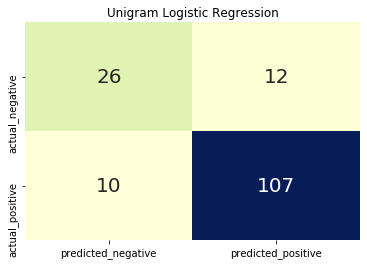

In [25]:
error = error_metrics(y_test_uni, y_pred_uni_LR)
error.show_heatmap('Unigram Logistic Regression')
results = pd.DataFrame(list(zip(error.metrics())), columns = ['unigram_LR'])
results = results.set_index([['accuracy', 'precision', 'recall', 'F1']])

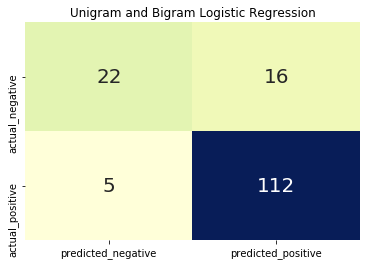

In [26]:
error = error_metrics(y_test_bi, y_pred_bi_LR)
error.show_heatmap('Unigram and Bigram Logistic Regression')
results = addResults(results, error.metrics(), 'bigram_LR')

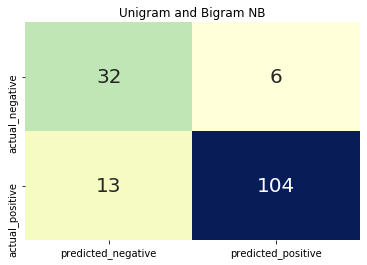

In [27]:
error = error_metrics(y_test_bi, y_pred_bi_NB)
error.show_heatmap('Unigram and Bigram NB')
results = addResults(results, error.metrics(), 'bigram_NB')

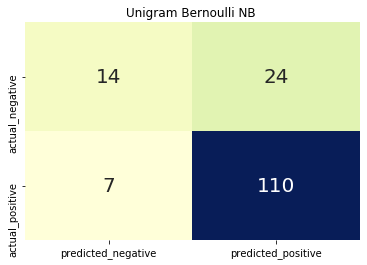

In [28]:
error = error_metrics(y_test_bi, y_pred_uni_BNB)
error.show_heatmap('Unigram Bernoulli NB ')
results = addResults(results, error.metrics(), 'unigram_BNB')

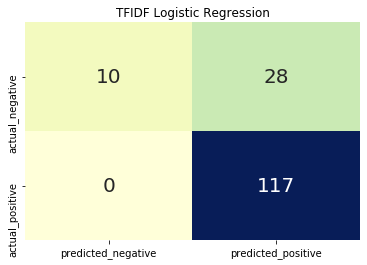

In [29]:
error = error_metrics(y_test_bi, y_pred_tfidf_LR)
error.show_heatmap('TFIDF Logistic Regression')
results = addResults(results, error.metrics(), 'tfidf_LR')

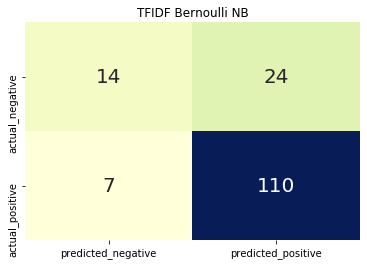

In [30]:
error = error_metrics(y_test_bi, y_pred_tfidf_BNB)
error.show_heatmap('TFIDF Bernoulli NB')
results = addResults(results, error.metrics(), 'tfidf_BNB')

In [31]:
results

,unigram_LR,bigram_LR,bigram_NB,unigram_BNB,tfidf_LR,tfidf_BNB
accuracy,0.858,0.865,0.877,0.800,0.819,0.800
precision,0.899,0.875,0.945,0.821,0.807,0.821
recall,0.915,0.957,0.889,0.940,1.000,0.940
F1,0.907,0.914,0.916,0.876,0.893,0.876
